In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #explore this plot package
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest
%config InlineBackend.figure_format = 'png' 
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore') # get rid of some warning messages-probably not a great idea

from patsy import dmatrices
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import KFold

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
train.head() #checking out the data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


('Skewness of the original target variable:', 1.880940746034036)


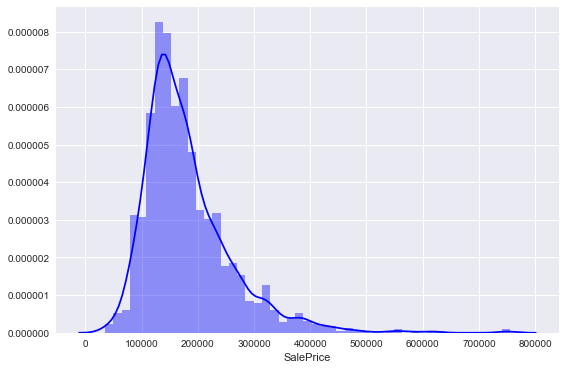

In [2]:
print("Skewness of the original target variable:", skew(train["SalePrice"]))

f, ax = plt.subplots(figsize=(9, 6))
sns.distplot(train['SalePrice'], color="b")

We see that the target variable is positively skewed.  
For linear and logistic regression we would like to make sure that the relationship between input variables and output variables is approximately linear, that the input variables are approximately normal in distribution, and that the output variable have constant variation (that is, the variance of the output variable is independent of the input variables).   
We might consider applying some (log) transformations in order to normalize the data.

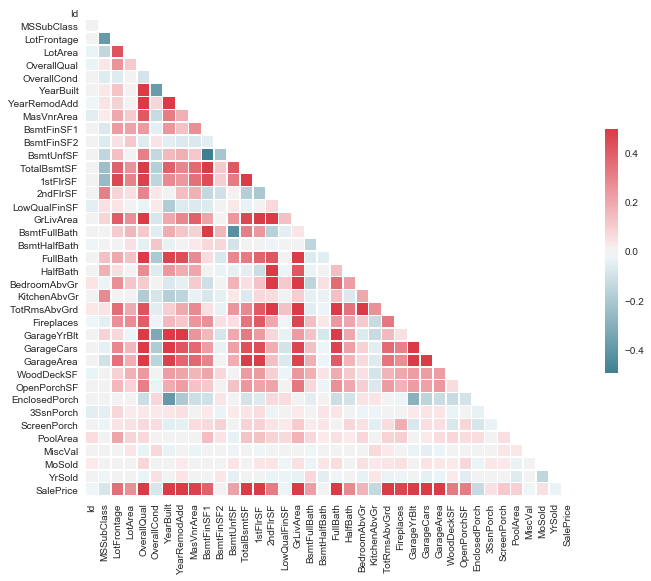

In [3]:
from string import ascii_letters

sns.set(style="white")


# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Maybe it's a good naive start on identifying strong correlation between Y and X and also a visual warning about correlation between many of the X's that needs to be dealt with.